In [28]:
import numpy as np
from matplotlib import pyplot as plt
#import seaborn

In [29]:
# seaborn.set_style('ticks')
# seaborn.set_style({"xtick.direction": "in","ytick.direction": "in", 'xtick.top':True, 'ytick.right':True})
# seaborn.set_context('paper')
# seaborn.set_palette('Dark2')

In [52]:
timings_file = '../output/theory_scaling_numpart_max0.1.npz'
print("Loading benchmarks from file = {0}".format(timings_file))
f = np.load(timings_file)

Loading benchmarks from file = ../output/theory_scaling_numpart_max0.1.npz


In [53]:
keys = f['keys']
isa = f['isa']
proj_types = f['proj_types']
runtimes = f['runtimes']
mock = 'mock' in timings_file
#runtimes = convert_numpy_bytes_to_unicode(runtimes)

In [54]:
plt_speedup = False
all_np = np.array(sorted(list(set(runtimes['ndata']))))
min_np = min(all_np)

In [55]:
for npart in all_np:
    print(" {0:7d} ".format(npart), end='')
    for mod in keys:
        for run_isa in isa:
            ind = (runtimes['ndata'] == npart) & \
                  (runtimes['name'] == mod) & \
                  (runtimes['isa'] == run_isa)
            s_ind = (runtimes['ndata'] == min_np) & \
                    (runtimes['name'] == mod) & \
                    (runtimes['isa'] == run_isa)

            # Note, this is only looking at the pair-counting time
            # and ignoring the total runtime ~ pair_time + serial_time
            # For the mocks, serial_time (~0.08 sec) *is* the limiting
            # factor in efficiency.
            serial_avg = (runtimes['pair_time'][s_ind]).mean()
            para_avg = (runtimes['pair_time'][ind]).mean()

            if plt_speedup:
                # If you want the Amdahl's law limited max. effiency,
                # uncomment the following lines.
                # serial_avg = np.mean(runtimes['runtime'][s_ind])
                # para_avg = np.mean(runtimes['runtime'][ind])
                # serial_para_runs = np.mean(runtimes['serial_time'][ind])
                # serial_serial_runs = np.mean(runtimes['serial_time'][s_ind])
                # theoretical_best_time = serial_runtime_in_parallel_runs + \
                #                         (serial_avg-serial_runtime_in_serial_runs)/it
                # print("{0:9.1f}({1:3.1f})".format((serial_avg/it)/para_avg*100,
                #                                   (serial_avg/it)/theoretical_best_time*100.0),
                #       end='')
                fallback_ind = (runtimes['ndata'] == npart) & \
                               (runtimes['name'] == mod) & \
                               (runtimes['isa'] == 'fallback')

                fallback_avg = (runtimes['pair_time'][fallback_ind]).mean()
                print("{0:12.1f}x ".format(fallback_avg/para_avg),
                      end='')

            else:
                print("{0:12.3f} ".format(para_avg),
                      end='')

        print("    |", end='')

     123        0.001        0.001     |     444        0.004        0.003     |    1596        0.037        0.020     |    5739        0.401        0.161     |   20630        5.023        1.842     |   74154       64.333       22.527     |

[   123    444   1596   5739  20630  74154 741540]
[2.23277815e-05 2.90938565e-04 3.75924928e-03 4.86080055e-02
 6.28107252e-01 8.11529883e+00 8.11529883e+02]


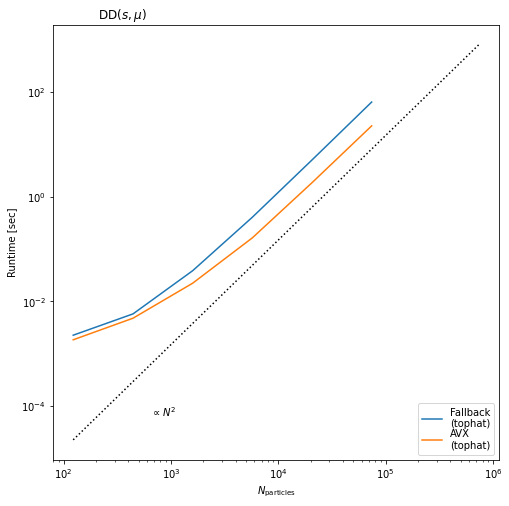

In [56]:
#assert len(keys) == 2
ncols = len(keys)
figwidth = 8*ncols
fig, axes = plt.subplots(nrows=1, ncols=ncols, sharex=True, sharey=True, squeeze=False, figsize=(figwidth,figwidth))
for ax in axes.T:
    ax[-1].set_xlabel(r'$N_\mathrm{particles}$')
for ax in axes:
    ax[0].set_ylabel(r'SIMD Speedup' if plt_speedup else 'Runtime [sec]')
fig.subplots_adjust(hspace=0, wspace=0)
axes = axes.reshape(-1)
plt_mod = {'DDrppi':r'$\mathrm{DD}(r_p,\pi)$', 'DD':r'$\mathrm{DD}(r)$', 'wp':r'$w_p(r_p)$', 'xi':r'$\xi(r)$',
           'DDrppi (DD)':r'$\mathrm{DD}(r_p,\pi)$', 'DDtheta (DD)':r'$\mathrm{DD}(\theta)$',
           'DDrppi (DR)':r'$\mathrm{DR}(r_p,\pi)$', 'DDtheta (DR)':r'$\mathrm{DR}(\theta)$',
           'DDsmu':r'$\mathrm{DD}(s,\mu)$'}

for mod,ax in zip(keys,axes):
    ax.set_title(plt_mod[mod], position=(0.1,0.8), loc='left')
    if plt_speedup:
        ax.set_xlim(1e3, 2e6)
        ax.set_ylim(0.5,5.0)

    plt_isa = {'avx512f':'AVX-512', 'avx':'AVX', 'sse42':'SSE 4.2', 'fallback':'Fallback'}
    plt_proj = {'None':'', 'tophat':'tophat'}
    for proj_type in proj_types:

        for run_isa in isa:
            rt = []

            for npart in all_np:
                s_ind = (runtimes['ndata'] == npart) & \
                        (runtimes['name'] == mod) & \
                        (runtimes['proj_type'] == proj_type) & \
                        (runtimes['isa'] == 'fallback')
                serial_avg = (runtimes['runtime'][s_ind]).mean()

                ind = (runtimes['ndata'] == npart) & \
                    (runtimes['name'] == mod) & \
                    (runtimes['proj_type'] == proj_type) & \
                    (runtimes['isa'] == run_isa)
                para_avg = (runtimes['runtime'][ind]).mean()
                rt += [serial_avg/para_avg if plt_speedup else para_avg]

            label = plt_isa[run_isa]
            if proj_type!='None':
                label += f'\n({plt_proj[proj_type]})'
            if plt_speedup:
                ax.semilogx(all_np, rt, label=label)
            else:
                ax.loglog(all_np, rt, label=label)

            if 'avx' == run_isa and not plt_speedup:
            #if proj_type=='None':
            #if run_isa=='fallback' and proj_type=='None':
                pltx = np.concatenate([all_np, [all_np[-1]*10]])
                plty = rt[-1]*(.6*pltx/pltx[-2])**2.
                ax.loglog(pltx, plty, ':', c='k')
                
                print(pltx)
                print(plty)
                
        axes[0].annotate(r'$\propto N^2$', xy=(.22, .1), xycoords='axes fraction')
        axes[-1].legend(loc='lower right', labelspacing=0.02)